# Projet naiades

par Charlotte Kruzic & Zoé Marquis

UE Entreposage et protection des données

Quel lien peut-on établir entre la physico-
chimie de l’eau et son état biologique ?

## TODO ZOE CHARLOTTE : 
Le problème posé. Le sujet est volontairement ouvert, il est nécessaire de bien cadrer la question
que l’on se pose, d’identifier les limites imposées et celles que vous décidez d’ajouter.

- reprendre dans le sujet les différentes contraintes
- puis formuler notre problématique 

une liste en dessous : 

- Comment l'évolution temporelle d'un paramètre physico-chimique spécifique (par exemple, les nitrates) affecte-t-elle l'état biologique de l'eau, et peut-on caractériser cette relation à l'aide de techniques de clustering?
- Un modèle de régression peut-il prédire avec précision l'indice biologique (I2M2) à partir des paramètres physico-chimiques, et si oui, quelles sont les implications pour la gestion et la surveillance de l'eau?
- Comment les variations spatiales des paramètres physico-chimiques et des indices biologiques diffèrent-elles entre les hydroécorégions de France, et quelles informations peut-on tirer de la comparaison de ces modèles avec les données géographiques?
- Comment les événements exceptionnels et les cycles saisonniers influencent-ils la relation entre les paramètres physico-chimiques et les indices biologiques, et quelles stratégies peuvent être employées pour prendre en compte ces facteurs dans les efforts de gestion et de surveillance de l'eau?

- pn pourra revoir toute la démarche pour chercher une problématique assez ciblé sur ce qu'on a fait

In [1]:
import geopandas as gpd

from matplotlib.patches import Patch
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from scipy.stats import zscore

import shapely.geometry as geom

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import zstandard as zstd


## Chargement des données

In [2]:
# stations
df_load_stations = pd.read_csv('data/stations_hb.csv.zst',sep=';',escapechar = '\\')
df_stations = df_load_stations.copy() # copy pour nettoyer etc mais garder l'original pour recouperer les infos

In [3]:
# pc : physicochimie
f="data/donnees_physicochimie.csv.zst"
pc_sample = pd.read_csv(f,nrows=1)
pc_list_cols = pc_sample.columns
pc_list_cat = pc_list_cols[pc_list_cols.str.startswith((
    'Lb','Nom','Mnemo',
    'Cd','Sym','Com'))]

pc_dict_cat = {col: 'category' for col in pc_list_cat}

df_load_pc = pd.read_csv(
        f,
        sep=',',
        engine='c',
        escapechar='\\',
        dtype=pc_dict_cat,
        parse_dates=[7],
        iterator=False)
df_pc = df_load_pc.copy()

In [4]:
# hydrobio
df_load_hydrobio = pd.read_csv('data/donnees_hydrobio.csv.zst',sep=',',escapechar = '\\')
df_hydrobio = df_load_hydrobio.copy()

In [5]:
# hydroecoregion
df_load_hydroregions = gpd.read_file("data/Hydroecoregion1-shp.zip")
df_hydroregions = df_load_hydroregions.copy()

## Analyse exploratoire

TODO ZOE rédiger : 
Objectif : que contient chaque dataset, identifier les colonnes à supprimer, comment remodeler les données...

### Données géographiques

In [6]:
df_stations.head(3)

,CdStationMesureEauxSurface,LbStationMesureEauxSurface,DurStationMesureEauxSurface,CoordXStationMesureEauxSurface,CoordYStationMesureEauxSurface,CdProjStationMesureEauxSurface,LibelleProjection,CodeCommune,LbCommune,CodeDepartement,...,DateMAJInfosStationMesureEauxSurface,FinaliteStationMesureEauxSurface,LocPreciseStationMesureEauxSurface,CodeNatureStationMesureEauxSurface,LibelleNatureStationMesureEauxSurface,AltitudePointCaracteritisque,PkPointTronconEntiteHydroPrincipale,PremierMoisAnneeEtiage,SuperficieBassinVersantReel,SuperficieBassinVersantTopo
0,01000477,LA SLACK À RINXENT (62),NaN,610228.78,7078879.90,26,RGF93 / Lambert 93,62711,RINXENT,62,...,2015-12-14 00:00:00,NaN,Lieu-dit Ferme du Château. La Planche du Devin,M,Station de mesure Manuelle,0.0,980.48,6.0,NaN,0.0
1,01000602,COLOGNE à BUIRE COURCELLES (80),NaN,700318.40,6980033.60,26,RGF93 / Lambert 93,80150,BUIRE-COURCELLES,80,...,2015-12-14 00:00:00,NaN,MOULIN DE BINARD PONT D 194 E,M,Station de mesure Manuelle,0.0,992.58,6.0,NaN,0.0
2,01000605,L'OMIGNON À DEVISE (80),NaN,700279.85,6973284.26,26,RGF93 / Lambert 93,80239,DEVISE,80,...,2015-12-14 00:00:00,NaN,ROUTE DE L'EGLISE,M,Station de mesure Manuelle,0.0,993.69,6.0,NaN,0.0


La table station est utile pour situer les stations ainsi que pour extraire l'identifiant pour joindre les tables sur les stations.

In [7]:
df_hydroregions.head(3)

,gid,CdHER1,NomHER1,geometry
0,1,16,CORSE,"POLYGON ((9.43319 43.00468, 9.4357 42.99999, 9..."
1,2,12,ARMORICAIN,"POLYGON ((-2.61068 48.55022, -2.61268 48.54898..."
2,3,13,LANDES,"MULTIPOLYGON (((-1.04228 45.54443, -1.03836 45..."


In [8]:
# On vérifie qu'on a bien un CdHER1 pour un NomHER1
print(df_hydroregions['CdHER1'].value_counts())

CdHER1
16    1
12    1
10    1
9     1
3     1
17    1
6     1
5     1
19    1
8     1
15    1
4     1
18    1
20    1
7     1
2     1
21    1
11    1
1     1
14    1
13    1
22    1
Name: count, dtype: int64


On a bien 1 CdHER1 pour 1 NomHER1, donc on va afficher la carte avec NomHER1 car cela est plus parlant pour l'utilisateur.

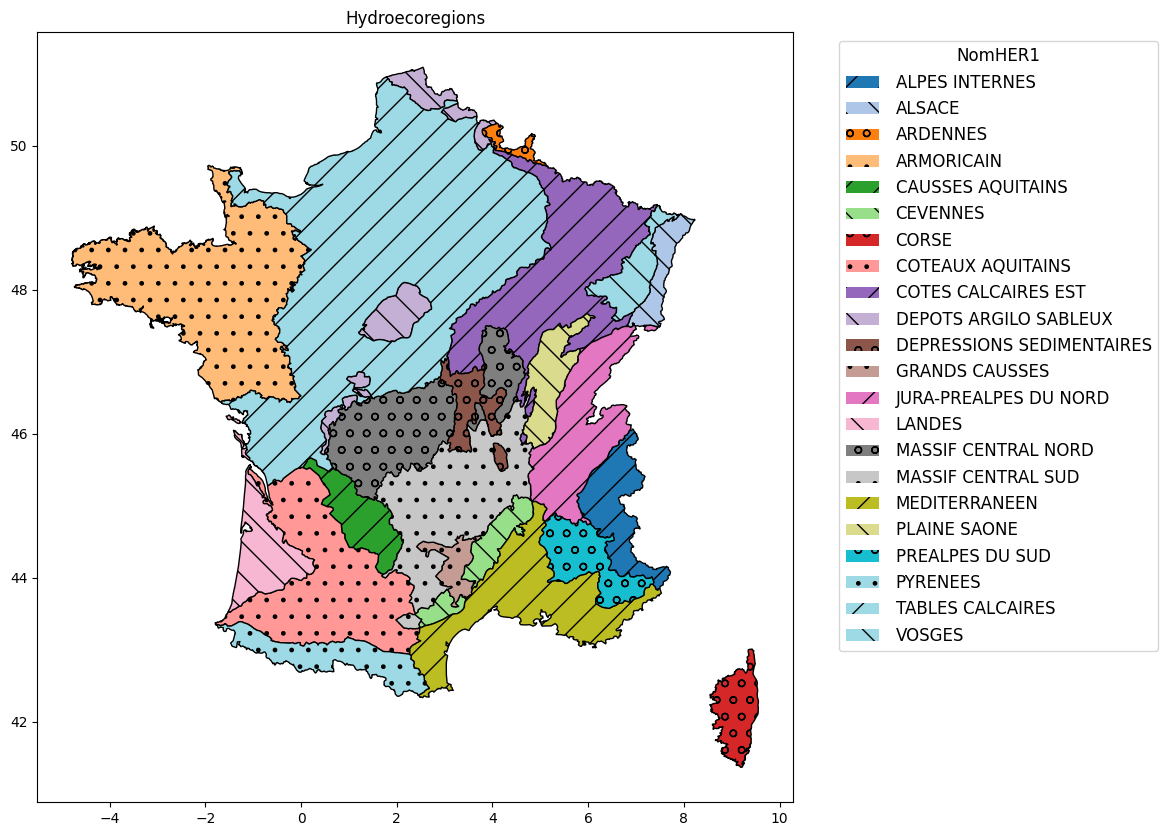

In [9]:
# Afficher les hydroeco regions

fig, ax = plt.subplots(figsize=(20, 10))

colors = plt.colormaps['tab20']
hatches = ['/', '\\', 'o', '.']
legend_elements = []

for i, (name, region) in enumerate(df_hydroregions.groupby('NomHER1')):
    patch = region.plot(ax=ax, color=colors(i), hatch=hatches[i % len(hatches)], edgecolor='black', label=name)
    legend_elements.append(Patch(facecolor=colors(i), hatch=hatches[i % len(hatches)], label=name))

ax.set_title('Hydroecoregions')

ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)

plt.show()


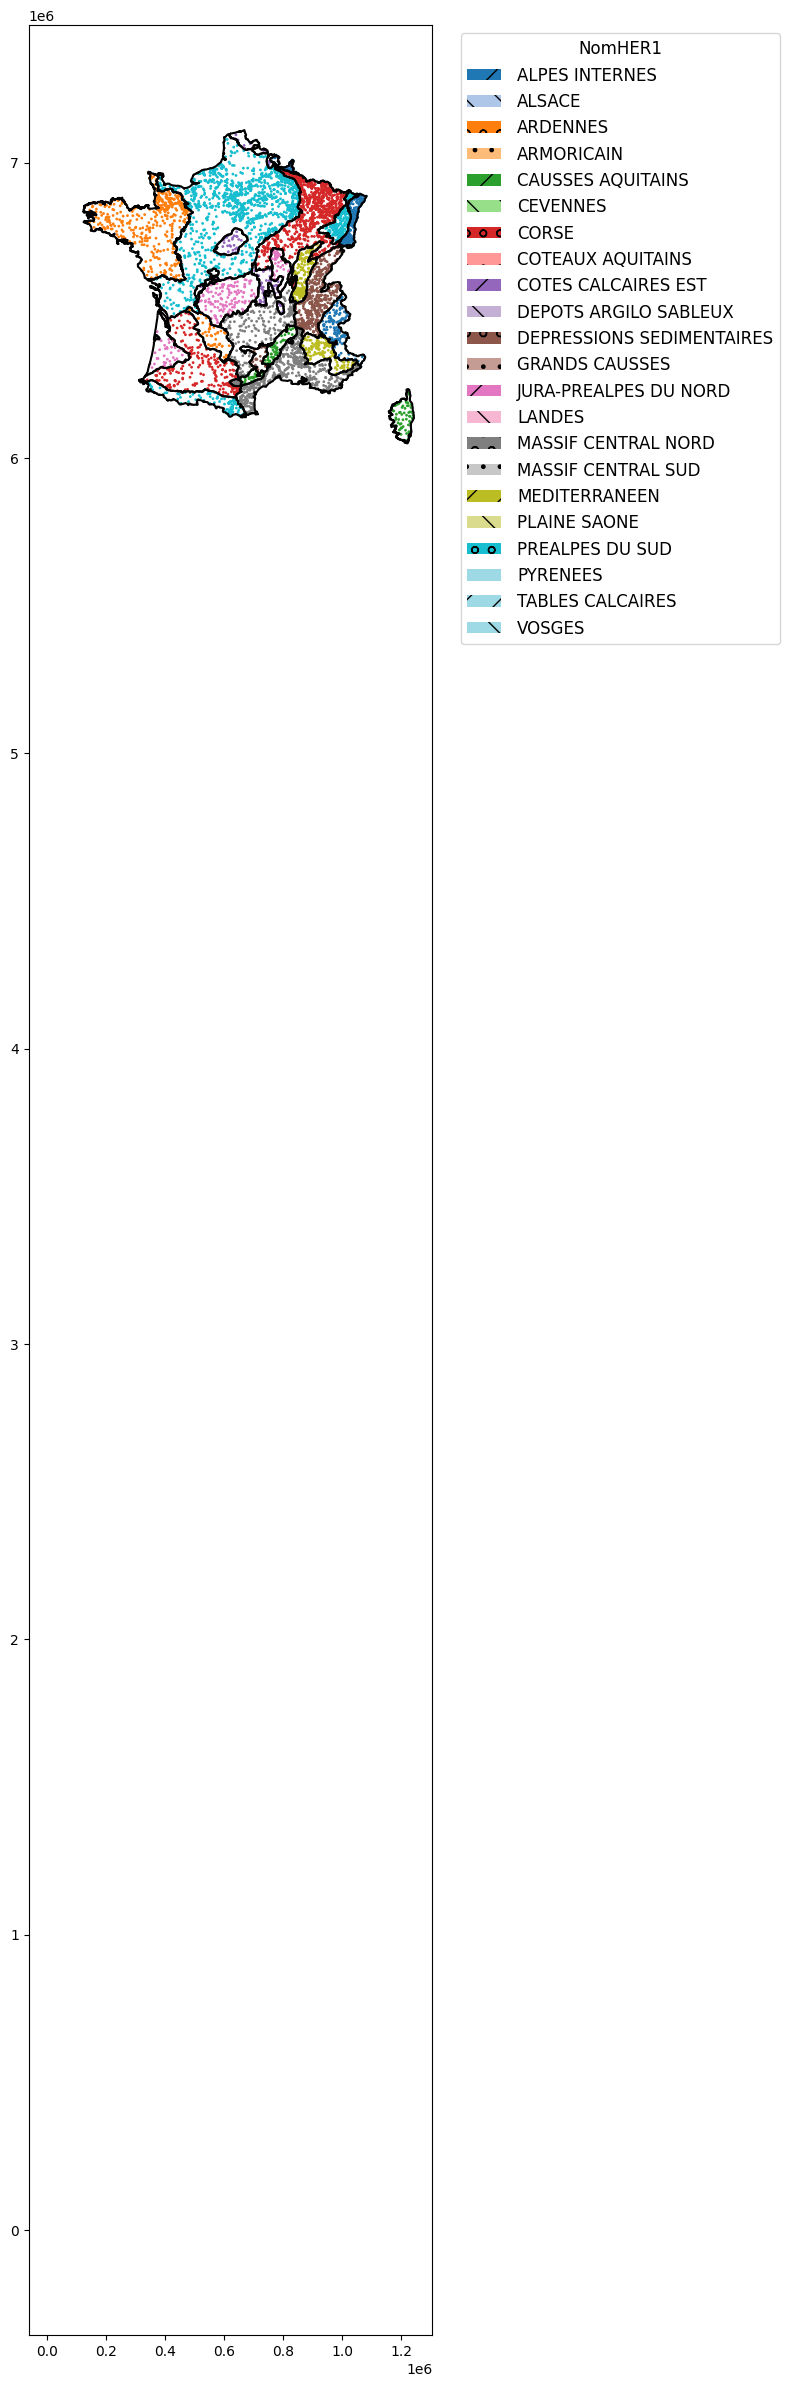

In [ ]:
# Situons les différentes stations de la table station dans la carte des hydroecoregions

# TODO CHARLOTTE : mettre la bonne forme de projection avec la bonne couleur pour les stations comme la cellule juste au dessus 

crs_lambert = 'PROJCS["RGF_1993_Lambert_93",GEOGCS["GCS_RGF_1993",DATUM["D_RGF_1993",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic"],PARAMETER["False_Easting",700000.0],PARAMETER["False_Northing",6600000.0],PARAMETER["Central_Meridian",3.0],PARAMETER["Standard_Parallel_1",49.0],PARAMETER["Standard_Parallel_2",44.0],PARAMETER["Latitude_Of_Origin",46.5],UNIT["Meter",1.0]]'
x_col = 'CoordXStationMesureEauxSurface'
y_col = 'CoordYStationMesureEauxSurface'
carto_i2m2 = gpd.GeoDataFrame(df_stations,crs=crs_lambert ,
                        geometry = gpd.GeoSeries(df_stations.agg(lambda x:geom.Point(x.loc[x_col],x.loc[y_col])  ,axis=1)))

HER_stations=carto_i2m2.sjoin(df_hydroregions.to_crs(crs_lambert),predicate='within').to_crs(crs_lambert)

fig, ax = plt.subplots(1, 1, figsize=(10, 30))
df_hydroregions.plot(column='NomHER1', legend=True, ax=ax)   
HER_lambert = df_hydroregions.to_crs(crs_lambert)
HER_stations.plot(column='NomHER1', legend=True, ax=ax, markersize=1)
HER_lambert.boundary.plot(ax=ax, color='black')

ax.legend(handles=legend_elements, title='NomHER1', bbox_to_anchor=(1.05, 1), loc='upper left',  fontsize='large', title_fontsize='large', handletextpad=1)

plt.show()


### Données physico-chimiques et hydrobiologiques

In [11]:
df_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8917443 entries, 0 to 8917442
Data columns (total 49 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   CdStationMesureEauxSurface  category      
 1   LbStationMesureEauxSurface  category      
 2   CdSupport                   category      
 3   LbSupport                   category      
 4   CdFractionAnalysee          category      
 5   LbFractionAnalysee          category      
 6   CdPrelevement               category      
 7   DatePrel                    datetime64[ns]
 8   HeurePrel                   object        
 9   CdParametre                 category      
 10  LbLongParamètre             category      
 11  RsAna                       float64       
 12  CdUniteMesure               category      
 13  SymUniteMesure              category      
 14  CdRqAna                     category      
 15  MnemoRqAna                  category      
 16  CdInsituAna       

In [11]:
df_pc.shape

(8917443, 49)

In [10]:
df_hydrobio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43535 entries, 0 to 43534
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          43535 non-null  int64  
 1   CdStationMesureEauxSurface          43535 non-null  int64  
 2   LbStationMesureEauxSurface          43535 non-null  object 
 3   CdPointEauxSurf                     43115 non-null  float64
 4   DateDebutOperationPrelBio           43535 non-null  object 
 5   CdSupport                           43535 non-null  int64  
 6   LbSupport                           43535 non-null  object 
 7   DtProdResultatBiologique            14829 non-null  object 
 8   CdParametreResultatBiologique       43535 non-null  int64  
 9   LbLongParametre                     43535 non-null  object 
 10  ResIndiceResultatBiologique         43522 non-null  float64
 11  CdUniteMesure                       43535

In [12]:
df_hydrobio.shape

(43535, 21)

# TODO ZOE reformuler 
on sait dans nos contraintes qu'on doit utiliser les données temporelles et spatiales

nous on aimerait utiliser les données temporelles et voir si on arrive à faire un clustering pour retrouver les hydroecoregions

pour exploiter la relation entre physico chimie et hydrobiologique on se doute que pc a un impact sur hydrobio

on voit bien qu'on a presqeu 9 millions de données pc

on va donc devoir nettoyer beaucoup ces données pour réduire pn a pas des machines super puissante
supprimer duplicatas, les données aberrantes
ce qui va etre challengeant car il y a tellement de données qu'on ne peut pas non plus beaucoup plot, donc on va devoir mettre en place des sytratégies pour supprimer sans perdre d'information

on va agréger déjà par saison par année les données par station

on va étudier quelles parametres / support / fraction / unité de mesure sont étudiés

on va pivoter pour enfaite obtenir une table qui 
par station, par saison par année, par paramètre intéressant de pc : médiane / moyenne des données (agréger suivant deux paramètres)

puis on va ajouter les données hydrobio

pour cela il faut donc faire la meme préparation
on pourrait utiliser lesvaleurs directement en agrégeant de la meme maniere
ou aussi les classes de l'url fourni dans l'énoncé

comme dit on pense que pc a un impact sur hydrobio
on va essayer différents laps de temps de décalage (1 mois, 3 mois, 6 mois) (à voir quand on aura fini)
pour voir si ça changebeaucoup la performance

ensuite joindre à notre table de pc plus legere agrégé nettoyé les données hydrobio
on ne garde que celle où c'est en commun avec station (on va utilser la table station pour join)

on fait un clustering sur le nombre de clusters de hydroecoregions (mais enfaite il faut qu'on véérifie une fois qu'on a join est ce qu'on a des données pour chaque hydroecoregions) si non on calcule quelle nombre on a ( on replot nos stations sur la map )

## Préparation des données physicochimiques

In [13]:
# combien de données dupliquéss ?
print(df_pc.duplicated().sum())

11836


In [14]:
# supprimer les doublons
df_pc.drop_duplicates(inplace=True)

## TODO ZOE : Notes sur les colonne à conserver
on émet l'hypothese que le laboratoire, le producteur, le préleveur et le rdd ne sont pas des données de pc, 
enfaite sur le nombre total de colonnes on va en garder tres peu

on pense que beauoup de données sobnt des metadonnées / 
on pense qu'ils sont censés pour un meme prelevement avoir les memes valeurs  
ce sont plutot des metadonnées sur le prelevement, on ne les prends pas en compte dans notre analyse  

puisqu'on va agréger par saison, on ne gardera pas non plus la colonne heure

## Caractériser une analyse physico chimique

Comme vu dans le TD, ce qui caractérise une analyse c'est : 
- le support
- le paramètre
- la fraction analysée
- dans quelle unité

In [15]:
print("Supports :", df_pc['LbSupport'].nunique(), "valeurs ->", df_pc['LbSupport'].unique().tolist())
print("Paramètres :", df_pc['LbLongParamètre'].nunique(), "valeurs ->", df_pc['LbLongParamètre'].unique().tolist())
print("Fractions :", df_pc['LbFractionAnalysee'].nunique(), "valeurs ->", df_pc['LbFractionAnalysee'].unique().tolist())
print("Unités :", df_pc['SymUniteMesure'].nunique(), "valeurs ->", df_pc['SymUniteMesure'].unique().tolist())

Supports : 5 valeurs -> ['Eau', 'Air', 'Sédiments', 'Diatomées benthiques', 'Gammares']
Paramètres : 16 valeurs -> ['Matières en suspension', 'Demande Biochimique en oxygène en 5 jours (D.B.O.5)', "Température de l'Eau", 'Potentiel en Hydrogène (pH)', 'Conductivité à 25°C', 'Oxygène dissous', 'Taux de saturation en oxygène', 'Phosphore total', 'Turbidité Formazine Néphélométrique', 'Azote Kjeldahl', 'Diuron', 'Carbone Organique', 'Ammonium', 'Nitrites', 'Nitrates', 'Orthophosphates (PO4)']
Fractions : 2 valeurs -> ['Eau brute', "Phase aqueuse de l'eau (filtrée, centrifugée...)"]
Unités : 15 valeurs -> ['mg/L', 'mg(O2)/L', '°C', 'unité pH', 'µS/cm', '%', 'mg(P)/L', 'NFU', 'mg(N)/L', 'µg/L', 'mg(C)/L', 'mg(NH4)/L', 'mg(NO2)/L', 'mg(NO3)/L', 'mg(PO4)/L']


On va analyser combien de parametres par fraction pr support par unité de mesure on a 

# TODO ZOE : reformuler

#### Fractions et Supports

In [15]:
test = df_pc[['LbSupport','LbFractionAnalysee']].drop_duplicates()

In [16]:
print('Nombre de fractions par support')
test.groupby(['LbSupport']).count()

Nombre de fractions par support


,LbFractionAnalysee
LbSupport,
Eau,2
Air,2
Sédiments,2
Diatomées benthiques,1
Gammares,1


Pour un support donné plusieurs fractions peuvent être analysées.

In [17]:
print('Nombre de supports par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de supports par fraction


,LbSupport
LbFractionAnalysee,
Eau brute,5
"Phase aqueuse de l'eau (filtrée, centrifugée...)",3


Pour une fraction donnée plusieurs supports peuvent être analysés.

#### Fractions et paramètres

In [18]:
test = df_pc[['LbLongParamètre','LbFractionAnalysee']].drop_duplicates()

In [19]:
print('Nombre de fractions par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de fractions par paramètre


,LbFractionAnalysee
LbLongParamètre,
Azote Kjeldahl,1
Conductivité à 25°C,1
Demande Biochimique en oxygène en 5 jours (D.B.O.5),1
Diuron,1
Matières en suspension,1
Oxygène dissous,1
Phosphore total,1
Potentiel en Hydrogène (pH),1
Taux de saturation en oxygène,1


Pour un paramètre donné un seul type de fraction est analysé.

In [20]:
print('Nombre de paramètres par fraction')
test.groupby(['LbFractionAnalysee']).count()

Nombre de paramètres par fraction


,LbLongParamètre
LbFractionAnalysee,
Eau brute,11
"Phase aqueuse de l'eau (filtrée, centrifugée...)",5


Pour une fraction donnée plusieurs paramètres peuvent être analysés.

#### Supports et paramètres

In [21]:
test = df_pc[['LbLongParamètre','LbSupport']].drop_duplicates()

In [22]:
print('Nombre de supports par paramètre')
test.groupby(['LbLongParamètre']).count()

Nombre de supports par paramètre


,LbSupport
LbLongParamètre,
Azote Kjeldahl,3
Conductivité à 25°C,4
Demande Biochimique en oxygène en 5 jours (D.B.O.5),3
Diuron,3
Matières en suspension,3
Oxygène dissous,4
Phosphore total,3
Potentiel en Hydrogène (pH),5
Taux de saturation en oxygène,4


Pour un paramètre donné plusieurs supports peuvent être utilisés.

In [ ]:
print('Nombre de paramètres par support')
test.groupby(['LbSupport']).count()
# 

Nombre de paramètres par support


,LbLongParamètre
LbSupport,
Eau,16
Air,14
Sédiments,14
Diatomées benthiques,2
Gammares,5


Pour un support donné plusieurs paramètres peuvent être analysés.

#### Unités de mesure et paramètres

In [23]:
test = df_pc[['LbLongParamètre','SymUniteMesure']].drop_duplicates()

In [24]:
print("Nombre d'unités par paramètre")
test.groupby(['LbLongParamètre']).count()

Nombre d'unités par paramètre


,SymUniteMesure
LbLongParamètre,
Azote Kjeldahl,1
Conductivité à 25°C,1
Demande Biochimique en oxygène en 5 jours (D.B.O.5),1
Diuron,1
Matières en suspension,1
Oxygène dissous,1
Phosphore total,1
Potentiel en Hydrogène (pH),1
Taux de saturation en oxygène,1


Pour un paramètre donné plusieurs unités une seule unité de mesure est utilisée.

In [25]:
print("Nombre de paramètres par unité")
test.groupby(['SymUniteMesure']).count()

Nombre de paramètres par unité


,LbLongParamètre
SymUniteMesure,
%,1
NFU,1
mg(N)/L,1
mg(O2)/L,2
mg(P)/L,1
mg/L,1
unité pH,1
°C,1
µS/cm,1


Pour une unité de mesure donnée plusieurs paramètres peuvent être analysés.

# TODO ZOE reformuler : 
### Quelles informations en extraire ?
on a pour chaque parametre analysé seulement une unité de mesure  
-> pas besoin de nettoyer ou de garder la colonne unité une fois qu'on aura basculer dans notre dataframe pour l'analyse

D'après les diapos 

Un résultat d’analyse (RsAna) se caractérise
principalement par  
- Un paramètre physico-chimique (nitrate, phosphate,
température, pH…) (CdParametre)  
- Une unité de mesure (CdUniteMesure)  
- Une fraction d’analyse (CdFractionAnalysee) à
partir d’un support de prélèvement (CdSupport)


Or ici on a vu qu'il n'y a qu'un paramètre par unité / une unité par paramètre.
On va donc basculer la table pour considérer pour chaque résultat d'analyse à la fois 
le paramètre, le support et la fraction.

In [ ]:
# Pour un paramètre donné, combien y a t il d'unité de mesure, de support et de fraction analysee ?
print(df_pc.groupby('LbLongParamètre')['SymUniteMesure'].nunique().value_counts())
print(df_pc.groupby('LbLongParamètre')['LbSupport'].nunique().value_counts())
print(df_pc.groupby('LbLongParamètre')['LbFractionAnalysee'].nunique().value_counts())

SymUniteMesure
1    16
Name: count, dtype: int64
LbSupport
3    9
4    3
5    2
1    2
Name: count, dtype: int64
LbFractionAnalysee
1    16
Name: count, dtype: int64


On a aussi vu que pour un paramètre donné un seul type de fraction est analysé  
regardons la combinaison des triplets : 

## TODO ZOE reformuler

In [26]:
# Pour un paramètre et un support donné, combien de fraction différentes sont analysées ?   
grouped = df_pc.groupby(['LbLongParamètre','LbSupport'])['LbFractionAnalysee'].nunique()
multiple_fractions = grouped[grouped > 1]
print(multiple_fractions)

Series([], Name: LbFractionAnalysee, dtype: int64)


On a au maximum 1 fraction pour un paramètre et un support donné.

La fraction peut donc être déduit uniquement à partir du couple paramètre, support.

On va donc faire un regroupement par tuple **paramètre, support**

In [27]:
params = df_pc.groupby(["LbLongParamètre",'LbSupport'])

In [29]:
# nombre de valeurs pour chaque tuple
params.size().sort_values(ascending=False)

LbLongParamètre                      LbSupport           
Potentiel en Hydrogène (pH)          Eau                     675940
Température de l'Eau                 Eau                     675906
Conductivité à 25°C                  Eau                     668744
Oxygène dissous                      Eau                     632623
Taux de saturation en oxygène        Eau                     613947
                                                              ...  
Turbidité Formazine Néphélométrique  Diatomées benthiques         0
                                     Gammares                     0
Carbone Organique                    Air                          0
                                     Sédiments                    0
Orthophosphates (PO4)                Gammares                     0
Length: 80, dtype: int64

In [30]:
# combien de résultats d'analyse pour chaque tuple ?
params_size = params.agg({'RsAna' : ['size']}) 

In [ ]:
# regardons combien de lignes sont vides (RsAna = 0)
params_size[params_size[('RsAna','size')]==0]

RsAna
                                                                         size
LbLongParamètre                                    LbSupport                 
Azote Kjeldahl                                     Diatomées benthiques     0
                                                   Gammares                 0
Conductivité à 25°C                                Diatomées benthiques     0
Demande Biochimique en oxygène en 5 jours (D.B.... Diatomées benthiques     0
                                                   Gammares                 0
Diuron                                             Diatomées benthiques     0
                                                   Gammares                 0
Matières en suspension                             Diatomées benthiques     0
                                                   Gammares                 0
Oxygène dissous                                    Diatomées benthiques     0
Phosphore total                                    Diatomées benthiques     0
                                                   Gammares                 0
Taux de saturation en oxygène                      Diatomées benthiques     0
Turbidité Formazine Néphélométrique                Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Carbone Organique                                  Air                      0
                                                   Sédiments                0
                                                   Diatomées benthiques     0
                                                   Gammares                 0
Ammonium                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrates                                           Diatomées benthiques     0
                                                   Gammares                 0
Nitrites                                           Diatomées benthiques     0
                                                   Gammares                 0
Orthophosphates (PO4)                              Diatomées benthiques     0
                                                   Gammares                 0

In [34]:
params_size[params_size[('RsAna','size')]!=0].sort_values(('RsAna','size'),ascending=True)

RsAna
                                                                           size
LbLongParamètre                                    LbSupport                   
Température de l'Eau                               Gammares                   1
Conductivité à 25°C                                Gammares                   1
Oxygène dissous                                    Gammares                   1
Taux de saturation en oxygène                      Gammares                   1
Potentiel en Hydrogène (pH)                        Gammares                   1
                                                   Diatomées benthiques      28
Température de l'Eau                               Diatomées benthiques      28
Diuron                                             Sédiments                 35
Azote Kjeldahl                                     Sédiments                 60
Potentiel en Hydrogène (pH)                        Sédiments                 78
Phosphore total                                    Sédiments                 78
Température de l'Eau                               Sédiments                 78
Ammonium                                           Sédiments                 78
Nitrates                                           Sédiments                 78
Nitrites                                           Sédiments                 78
Taux de saturation en oxygène                      Sédiments                 78
Oxygène dissous                                    Sédiments                 78
Orthophosphates (PO4)                              Sédiments                 78
Matières en suspension                             Sédiments                 78
Demande Biochimique en oxygène en 5 jours (D.B.... Sédiments                 78
Conductivité à 25°C                                Sédiments                 78
Diuron                                             Air                     1046
Azote Kjeldahl                                     Air                     2136
Ammonium                                           Air                     3059
Phosphore total                                    Air                     3061
Demande Biochimique en oxygène en 5 jours (D.B.... Air                     3145
Matières en suspension                             Air                     3148
Nitrates                                           Air                     3149
Nitrites                                           Air                     3149
Orthophosphates (PO4)                              Air                     3149
Taux de saturation en oxygène                      Air                     3169
Oxygène dissous                                    Air                     3395
Température de l'Eau                               Air                     3402
Potentiel en Hydrogène (pH)                        Air                     3428
Conductivité à 25°C                                Air                     3432
Diuron                                             Eau                   279124
Turbidité Formazine Néphélométrique                Eau                   420400
Ammonium                                           Eau                   509158
Azote Kjeldahl                                     Eau                   525943
Nitrites                                           Eau                   531995
Carbone Organique                                  Eau                   535869
Demande Biochimique en oxygène en 5 jours (D.B.... Eau                   542836
Orthophosphates (PO4)                              Eau                   543972
Nitrates                                           Eau                   550019
Phosphore total                                    Eau                   569020
Matières en suspension                             Eau                   587151
Taux de saturation en oxygène                      Eau                   613947
Oxygène dissous                                    Eau                   6

sur toutes les mesures, on voit qu'il n'y en a qu'une de Support Gammares 
38 de diatomées benthiques
et maximum 80 pour sédiments... 

en comparaison avec les milliers pour l'air, et les centaines de milliers de pour l'eau : 

on risque sous représentation de ces différents supports 

TODO : étudier où sont les pas beaucoup, tous sur meme station ? si oui : inutile de les garder

stratégies possibles : 
- over sampling 
- supprimer ces lignes

pour l'instant : rien on garde comme c'est 


In [35]:
# Conversion en chaînes de caractères avant concaténation
param_series = df_pc['LbLongParamètre'].astype(str) + ' - ' + df_pc['LbSupport'].astype(str)

Prendre en compte les seuils : (RqAna)

In [36]:
# traiter les seuils
df_pc[['CdRqAna','MnemoRqAna']].value_counts()

CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
0        Analyse non faite                                                                   10400
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
8        Dénombrement > Valeur                                                                  64
9        Dénombrement < Valeur                                                                   1
11       Echelle Absente                                                                         1
Name: count, dtype: i

d'après la doc : 
- 1 = ok : rien besoin de faire 
- 0 : analyse non faite -> le résultat doit être vide : nous on va supprimer ces lignes
- 2 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils : TODO le vérifier
- 3 : le résultat donne alors la valeur du seuil de saturation : TODO vérifier
- 7 : le résultat prend alors la valeur du seuil de détection ou du seuil de quantification suivant qu'il est inférieur à l'un de ces deux seuils. (comme 2) : TODO idem
- 8 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation).
- 9 : Les codes remarque 8 et 9 doivent être utilisés pour qualifier des résultats fournis par des méthodes de type qualitatif, décrits par rapport à un seuil bien que compris dans la plage d’utilisation courante des méthodes (supérieur au seuil de quantification et inférieur au seuil de saturation).
TODO pour 8 et 9 : je sais pas ce qu'on est censé faire de cette info à part supprimer ces lignes 
- 10 : Le résultat quant à lui prend la valeur du seuil de quantification. : TODO vérifier mais rien besoin de faire
- 11 : pas de doc -> supprimer cette valeur

pour tous les TODO vérifier : on a pas besoin de modifier les valeurs 

In [37]:
# Vérification des lignes avant la suppression
print("Avant suppression:", df_pc.shape)

# Suppression des lignes avec les codes spécifiques
df_pc = df_pc[~df_pc['CdRqAna'].isin(['0', '8', '9', '11'])]

# Vérification des lignes après la suppression
print("Après suppression:", df_pc.shape)

# Affichage des valeurs uniques restantes
print(df_pc[['CdRqAna', 'MnemoRqAna']].value_counts())


Avant suppression: (8905607, 49)
Après suppression: (8895141, 49)
CdRqAna  MnemoRqAna                                                                    
1        Résultat > seuil de quantification et < au seuil de saturation ou Résultat = 0    7764758
10       Résultat < au seuil de quantification                                             1125177
2        Résultat < seuil de détection                                                        3157
7        Traces (< seuil de quantification et > seuil de détection)                           1812
3        Résultat > seuil de saturation                                                        237
Name: count, dtype: int64


In [38]:
# TODO : cellule pour vérifier 2, 3, 7, 10


In [39]:
df_pc_light = df_pc[['CdStationMesureEauxSurface','DatePrel','RsAna']] # pour un parametre/support donné, un résultat d'analyse à une date donnée
df_pc_light['param'] = param_series
df_pc_light 

/var/folders/p1/4yqk4cyx3058m3j04rtkr56m0000gn/T/ipykernel_5286/2293102865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pc_light['param'] = param_series


,CdStationMesureEauxSurface,DatePrel,RsAna,param
0,05005600,2005-07-06,3.000,Matières en suspension - Eau
1,05200115,2005-09-28,0.700,Demande Biochimique en oxygène en 5 jours (D.B...
2,05001800,2005-01-19,8.100,Température de l'Eau - Eau
3,05001800,2005-01-19,7.800,Potentiel en Hydrogène (pH) - Eau
4,05001800,2005-01-19,845.000,Conductivité à 25°C - Eau
...,...,...,...,...
8917438,06133330,2022-10-25,0.010,Nitrites - Eau
8917439,06133330,2022-10-25,0.960,Nitrates - Eau
8917440,06133330,2022-10-25,0.005,Phosphore total - Eau
8917441,06133330,2022-10-25,0.010,Orthophosphates (PO4) - Eau


In [40]:
# supprimer les lignes où pour un paramètre donné on a moins de 1000 valeurs
df_pc_light = df_pc_light.groupby('param').filter(lambda x: x['RsAna'].count() > 1000)

In [41]:
# afficher les lignes où RsAna est vide
df_pc_light[df_pc_light['RsAna'].isnull()]

,CdStationMesureEauxSurface,DatePrel,RsAna,param


In [42]:
# afficher les doublons
df_pc_light[df_pc_light.duplicated()]

,CdStationMesureEauxSurface,DatePrel,RsAna,param
21474,05215100,2005-07-04,16.3,Température de l'Eau - Eau
35195,02018000,2005-05-03,15.5,Température de l'Eau - Eau
35196,02018000,2005-05-03,7.9,Potentiel en Hydrogène (pH) - Eau
35199,02018000,2005-05-03,9.0,Oxygène dissous - Eau
35581,02025500,2005-05-09,11.3,Température de l'Eau - Eau
...,...,...,...,...
8878024,06213370,2022-11-15,13.0,Température de l'Eau - Eau
8878932,06002058,2022-11-15,483.0,Conductivité à 25°C - Eau
8878933,06002058,2022-11-15,9.4,Oxygène dissous - Eau
8878934,06002058,2022-11-15,8.0,Potentiel en Hydrogène (pH) - Eau


In [43]:
# supprimer les doublons
print("Avant suppression:", df_pc_light.shape)
df_pc_light.drop_duplicates(inplace=True)
print("Après suppression:", df_pc_light.shape)

Avant suppression: (8894049, 4)
Après suppression: (8810625, 4)


In [44]:
# pour un paramètre donné à une station donné à une date donnée, y a t il plusieurs résultats d'analyse ?

In [45]:
duplicates = df_pc_light[df_pc_light.duplicated(subset=['CdStationMesureEauxSurface', 'param', 'DatePrel'], keep=False)]

In [46]:
duplicates.shape

(40987, 4)

In [ ]:
# oui : on conserve tout 

# Inspection : recherche de valeurs aberrantes

On a essayé d'afficher les outliers : trop de points, trop lourd, trop long : mais on a vu que pour certains paramètres il y avait clairements des valeurs aberranttes : 
Température de l'eau = -9999.0

Il faut donc clairement traiter ces cas

On a étudié plusieurs manières de regrouper les outliers (IQR, zscore, avec différents seuils)

In [ ]:
from scipy.stats import zscore

outliers_summary = []
cleaned_dataframes = []

for param in df_pc_light['param'].unique():
    df_param = df_pc_light[df_pc_light['param'] == param].copy()
    df_param['zscore'] = zscore(df_param['RsAna'])
    outliers = df_param[abs(df_param['zscore']) > 3]
    outliers_summary.append({
        "param": param,
        "total_values": len(df_param),
        "outliers_count": len(outliers),
        "outliers_percent": len(outliers) / len(df_param) * 100,
        "min_outlier": outliers['RsAna'].min() if not outliers.empty else None,
        "max_outlier": outliers['RsAna'].max() if not outliers.empty else None,
    })
    
    df_cleaned = df_param[abs(df_param['zscore']) <= 3].copy()
    df_cleaned.drop(columns=['zscore'], inplace=True)
    cleaned_dataframes.append(df_cleaned)

outliers_summary_df = pd.DataFrame(outliers_summary)

print("Résumé des outliers par paramètre :")
print(outliers_summary_df)

Résumé des outliers par paramètre :
                                                param  total_values  \
0                        Matières en suspension - Eau        584610   
1   Demande Biochimique en oxygène en 5 jours (D.B...        541160   
2                          Température de l'Eau - Eau        656418   
3                   Potentiel en Hydrogène (pH) - Eau        652628   
4                           Conductivité à 25°C - Eau        649121   
5                               Oxygène dissous - Eau        629463   
6                 Taux de saturation en oxygène - Eau        610779   
7                               Phosphore total - Eau        565122   
8           Turbidité Formazine Néphélométrique - Eau        419605   
9                                Azote Kjeldahl - Eau        524334   
10                                       Diuron - Eau        278229   
11                            Carbone Organique - Eau        534038   
12                                     Am

In [68]:

# Crée un DataFrame propre pour le traitement
df_cleaned = df_pc_light.copy()

# Liste pour stocker les résumés des outliers
outliers_summary_before = []

# Boucle sur chaque paramètre
for param in df_cleaned['param'].unique():
    df_param = df_cleaned[df_cleaned['param'] == param].copy()
    
    # Calcul du Z-score pour identifier les outliers
    df_param['zscore'] = zscore(df_param['RsAna'])
    
    # Identification des outliers avant imputation
    outliers_before = df_param[abs(df_param['zscore']) > 3]
    
    # Résumé des outliers avant imputation
    outliers_summary_before.append({
        "param": param,
        "total_values": len(df_param),
        "outliers_count_before": len(outliers_before),
        "outliers_percent_before": len(outliers_before) / len(df_param) * 100,
    })
    
    # Imputation des outliers avec la médiane
    median_value = df_param['RsAna'].median()
    df_param.loc[abs(df_param['zscore']) > 3, 'RsAna'] = median_value
    
    # Identification des outliers après imputation (cela doit être zéro)
    df_param['zscore'] = zscore(df_param['RsAna'])  # Recalculer le zscore après imputation
    outliers_after = df_param[abs(df_param['zscore']) > 3]
    
    # Remplacer les données dans le DataFrame global
    df_cleaned.loc[df_cleaned['param'] == param, 'RsAna'] = df_param['RsAna']
    
# Convertir les résumés en DataFrame pour une visualisation facile
outliers_summary_before_df = pd.DataFrame(outliers_summary_before)

print("Résumé des outliers avant imputation :")
print(outliers_summary_before_df)

Résumé des outliers avant imputation :
                                                param  total_values  \
0                        Matières en suspension - Eau        584610   
1   Demande Biochimique en oxygène en 5 jours (D.B...        541160   
2                          Température de l'Eau - Eau        656418   
3                   Potentiel en Hydrogène (pH) - Eau        652628   
4                           Conductivité à 25°C - Eau        649121   
5                               Oxygène dissous - Eau        629463   
6                 Taux de saturation en oxygène - Eau        610779   
7                               Phosphore total - Eau        565122   
8           Turbidité Formazine Néphélométrique - Eau        419605   
9                                Azote Kjeldahl - Eau        524334   
10                                       Diuron - Eau        278229   
11                            Carbone Organique - Eau        534038   
12                                    

On a remplacé par la médiane associée à chaque paramètre les outliers.  
Pour tous les paramètres, moins de 2% étaient des outliers, on pense donc avoir minimisé la perte d'information.  
Seulement le dernier paramètre : Diuron - Air avait plus de 2% (2.29%) d'outliers, qui ont été imputés.  

# Première visualisation : aggrégation par saison

In [80]:
df_pc_season = df_cleaned.copy() 

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'
    
df_pc_season['saison'] = df_pc_season['DatePrel'].dt.month.apply(assign_season)
df_pc_season['année'] = df_pc_season['DatePrel'].dt.year

df_counts = df_pc_season.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

In [1]:
season_colors = {
    "Printemps": "#77DD77",
    "Été": "#FFB347",
    "Automne": "#FF6961",
    "Hiver": "#AEC6CF"
}

In [ ]:
# Créer un graphique à barres
fig = px.bar(df_counts, 
             x='année', 
             y='nombre de résultats d\'analyse par saison', 
             color='saison', # TODO 
             barmode='stack', 
             labels={'Année': 'année', 'Nombre de valeurs': 'Nombre de Mesures'},
             title='Nombre de Mesures par Année et Saison')

# Personnaliser l'apparence
fig.update_layout(
    xaxis_title='année',
    yaxis_title='nombre de résultats d\'analyse',
    legend_title='saison'
)

# Afficher le graphique
fig.show()


NameError: name 'px' is not defined

On a plus de 300 k résultats tous les ans (plus ou moins équilibrés entre les saisons) à partir de 2007 jusque 2021.
Pour 2005, 2006 et 2022, on a plus de 200k résultats.

Grouper par station, année et saison.  
Calculer des statistiques représentatives (par exemple, la médiane ou la moyenne).  
Remplacer les valeurs dans le DataFrame par ces statistiques représentatives.  

In [83]:
df_pc_season.rename(columns={'CdStationMesureEauxSurface': 'station', 'DatePrel': 'date'}, inplace=True)

In [114]:
agg_functions = {
    'RsAna': ['mean', 'median'],
}
df_aggregated = df_pc_season.groupby(['station', 'param', 'saison', 'année']).agg(agg_functions).reset_index()
df_aggregated.columns = ['station', 'param', 'saison', 'année', 'mean_RsAna', 'median_RsAna']

print(f"Taille du DataFrame après l'agrégation avec différentes fonctions : {df_aggregated.shape[0]}")

Taille du DataFrame après l'agrégation avec différentes fonctions : 19029600


In [97]:
# on a beacucoup plus de valeurs : il doit y avoir beaucoup de null
df_aggregated.isnull().sum()

station                0
param                  0
saison                 0
année                  0
mean_RsAna      14970110
median_RsAna    14970110
dtype: int64

In [100]:
# supprimer toutes les lignes avec des valeurs nulles
df_aggregated.dropna(inplace=True)
df_aggregated.shape

(4059490, 6)

In [102]:
# calculer combien de moins ça fait par rapport à avant aggregation
print("nombre de valeurs en moins par rapport à avant aggrégation :", df_pc_season.shape[0] - df_aggregated.shape[0])
print("ce qui représente une perte de :", (df_pc_season.shape[0] - df_aggregated.shape[0]) / df_pc_season.shape[0] * 100, "%")

nombre de valeurs en moins par rapport à avant aggrégation : 4751135
ce qui représente une perte de : 53.92506206994396 %


In [103]:
df_aggregated

,station,param,saison,année,mean_RsAna,median_RsAna
74,05001800,Ammonium - Eau,Automne,2007,0.025,0.025
75,05001800,Ammonium - Eau,Automne,2008,0.045,0.045
76,05001800,Ammonium - Eau,Automne,2009,0.040,0.040
77,05001800,Ammonium - Eau,Automne,2010,0.022,0.020
78,05001800,Ammonium - Eau,Automne,2011,0.030,0.030
...,...,...,...,...,...,...
19029383,06148115,Taux de saturation en oxygène - Eau,Été,2022,90.000,90.000
19029473,06148115,Température de l'Eau - Eau,Automne,2022,12.300,12.300
19029491,06148115,Température de l'Eau - Eau,Hiver,2022,7.900,7.900
19029509,06148115,Température de l'Eau - Eau,Printemps,2022,11.900,11.900


## On refait pivoter notre dataframe : on veut résumer pour une station donnée à une saison donnée, le résulat d'analyse moyen ou médian (deux dataframes) pour chaque param

In [105]:
params = df_aggregated['param'].unique()
params

array(['Ammonium - Eau', 'Azote Kjeldahl - Eau',
       'Carbone Organique - Eau', 'Conductivité à 25°C - Eau',
       'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau',
       'Diuron - Eau', 'Matières en suspension - Eau', 'Nitrates - Eau',
       'Nitrites - Eau', 'Orthophosphates (PO4) - Eau',
       'Oxygène dissous - Eau', 'Phosphore total - Eau',
       'Potentiel en Hydrogène (pH) - Eau',
       'Taux de saturation en oxygène - Eau',
       "Température de l'Eau - Eau",
       'Turbidité Formazine Néphélométrique - Eau', 'Ammonium - Air',
       'Conductivité à 25°C - Air',
       'Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air',
       'Matières en suspension - Air', 'Nitrates - Air', 'Nitrites - Air',
       'Orthophosphates (PO4) - Air', 'Oxygène dissous - Air',
       'Phosphore total - Air', 'Potentiel en Hydrogène (pH) - Air',
       'Taux de saturation en oxygène - Air',
       "Température de l'Eau - Air", 'Azote Kjeldahl - Air',
       'Diuron - Ai

In [ ]:
df_aggregated = df_aggregated[['station', 'année', 'saison', 'param', 'median_RsAna']]

# Pivot des données : station, année, saison en index, param en colonnes
df_pivoted = df_aggregated.pivot_table(index=['station', 'année', 'saison'], 
                                       columns='param', 
                                       values='median_RsAna', 
                                       aggfunc='median')
df_pivoted.reset_index(inplace=True)

Aperçu du DataFrame pivoté :
param   station  année     saison  Ammonium - Air  Ammonium - Eau  \
0      05001800   2005    Automne             NaN             NaN   
1      05001800   2005      Hiver             NaN             NaN   
2      05001800   2005  Printemps             NaN             NaN   
3      05001800   2005        Été             NaN             NaN   
4      05001800   2007    Automne             NaN           0.025   

param  Azote Kjeldahl - Air  Azote Kjeldahl - Eau  Carbone Organique - Eau  \
0                       NaN                   NaN                      NaN   
1                       NaN                   NaN                      NaN   
2                       NaN                   NaN                      NaN   
3                       NaN                   NaN                      NaN   
4                       NaN                   1.0                     2.75   

param  Conductivité à 25°C - Air  Conductivité à 25°C - Eau  ...  \
0                  

In [122]:
df_pivoted.head(5)

param,station,année,saison,Ammonium - Air,Ammonium - Eau,Azote Kjeldahl - Air,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Air,Conductivité à 25°C - Eau,...,Oxygène dissous - Eau,Phosphore total - Air,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Air,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Air,Taux de saturation en oxygène - Eau,Température de l'Eau - Air,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau
0,05001800,2005,Automne,NaN,NaN,NaN,NaN,NaN,NaN,603.0,...,7.50,NaN,0.05,NaN,7.5,NaN,82.0,NaN,19.60,NaN
1,05001800,2005,Hiver,NaN,NaN,NaN,NaN,NaN,NaN,825.0,...,11.95,NaN,0.05,NaN,7.9,NaN,103.5,NaN,8.95,NaN
2,05001800,2005,Printemps,NaN,NaN,NaN,NaN,NaN,NaN,779.0,...,10.10,NaN,0.05,NaN,8.0,NaN,104.0,NaN,16.90,NaN
3,05001800,2005,Été,NaN,NaN,NaN,NaN,NaN,NaN,630.0,...,7.90,NaN,0.05,NaN,7.7,NaN,88.0,NaN,23.10,NaN
4,05001800,2007,Automne,NaN,0.025,NaN,1.0,2.75,NaN,770.0,...,9.10,NaN,0.05,NaN,8.0,NaN,94.0,NaN,14.40,NaN


In [123]:
print(f"Taille du DataFrame pivoté : {df_pivoted.shape[0]}")

Taille du DataFrame pivoté : 288975


In [124]:
df_pivoted.isnull().sum()

param
station                                                           0
année                                                             0
saison                                                            0
Ammonium - Air                                               287045
Ammonium - Eau                                                44763
Azote Kjeldahl - Air                                         287666
Azote Kjeldahl - Eau                                          41766
Carbone Organique - Eau                                       36355
Conductivité à 25°C - Air                                    286881
Conductivité à 25°C - Eau                                      6980
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    287014
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau     30399
Diuron - Air                                                 288221
Diuron - Eau                                                 159301
Matières en suspension - Air              

In [126]:
# pourcentage de valeurs nulles pour chaque paramètre
null_percentages = df_pivoted.isnull().mean() * 100
null_percentages

param
station                                                       0.000000
année                                                         0.000000
saison                                                        0.000000
Ammonium - Air                                               99.332122
Ammonium - Eau                                               15.490267
Azote Kjeldahl - Air                                         99.547020
Azote Kjeldahl - Eau                                         14.453153
Carbone Organique - Eau                                      12.580673
Conductivité à 25°C - Air                                    99.275370
Conductivité à 25°C - Eau                                     2.415434
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Air    99.321395
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    10.519595
Diuron - Air                                                 99.739078
Diuron - Eau                                                 55.126222


In [ ]:
# TODO : supprimer tout ce qui a plus de 90 % de null comme param ? drop la colonne ? 

In [ ]:
# intégrer les données hydrobiologiques
# on va faire une jointure sur les stations et les dates


In [ ]:
# TODO : lag : on va ajouter les valeurs de la saison suivante pour chaque paramètre

## Données hydrobio : les résumer pour pouvoir les intégrer dans notre dataframe

In [155]:
df_load_hydrobio.dtypes

Unnamed: 0                              int64
CdStationMesureEauxSurface              int64
LbStationMesureEauxSurface             object
CdPointEauxSurf                       float64
DateDebutOperationPrelBio              object
CdSupport                               int64
LbSupport                              object
DtProdResultatBiologique               object
CdParametreResultatBiologique           int64
LbLongParametre                        object
ResIndiceResultatBiologique           float64
CdUniteMesure                          object
SymUniteMesure                         object
CdRqIndiceResultatBiologique            int64
MnemoRqAna                             object
CdMethEval                             object
RefOperationPrelBio                    object
CdProducteur                            int64
NomProducteur                          object
CdAccredRsIndiceResultatBiologique    float64
MnAccredRsIndiceResultatBiologique     object
dtype: object

In [187]:
df_hydrobio.rename(columns={'CdStationMesureEauxSurface': 'station', 'DateDebutOperationPrelBio': 'date', 'ResIndiceResultatBiologique': 'I2M2'}, inplace=True)

In [188]:
# supprimer les I2M2 manquants et les doublons
print("avant suppression :", df_hydrobio.shape)
df_hydrobio.dropna(subset=['I2M2'], inplace=True)
df_hydrobio.drop_duplicates(inplace=True)
print("après suppression :", df_hydrobio.shape)

avant suppression : (43535, 21)
après suppression : (43522, 21)


In [189]:
df_hydrobio['date'] = pd.to_datetime(df_hydrobio['date'], format='%Y-%m-%d')

In [190]:
df_hydrobio['date'].dtype

dtype('<M8[ns]')

In [ ]:
# TODO : gérer les seuils de hydrobio 

In [191]:
df_hydrobio_saison = df_hydrobio.copy()
df_hydrobio_saison['saison'] = df_hydrobio_saison['date'].dt.month.apply(assign_season)
df_hydrobio_saison['année'] = df_hydrobio_saison['date'].dt.year

df_hydrobio_saison = df_hydrobio_saison[['station', 'année', 'saison', 'I2M2']]
df_hydrobio_saison

,station,année,saison,I2M2
8857,1000274,2016,Automne,0.243
16877,1000274,2017,Été,0.231
16878,1000274,2018,Été,0.205
24919,1000274,2019,Été,0.236
24920,1000274,2020,Été,0.096
...,...,...,...,...
8855,6999180,2013,Été,0.413
8856,6999180,2014,Été,0.437
41144,6999189,2022,Automne,0.454
41145,6999190,2022,Automne,0.257


In [192]:
df_counts = df_hydrobio_saison.groupby(['année', 'saison']).size().reset_index(name='nombre de résultats d\'analyse par saison')

In [ ]:
# TODO : ajouter couleurs pour les saisons à fixer 

In [193]:
# Créer un graphique à barres
fig = px.bar(df_counts, 
             x='année', 
             y='nombre de résultats d\'analyse par saison', 
             color='saison', 
             barmode='stack', 
             labels={'Année': 'année', 'Nombre de valeurs': 'Nombre de Mesures'},
             title='Nombre de Mesures par Année et Saison')

# Personnaliser l'apparence
fig.update_layout(
    xaxis_title='année',
    yaxis_title='nombre de résultats d\'analyse',
    legend_title='saison'
)

# Afficher le graphique
fig.show()


Cette fois ci on voit qu'on a surtout des résultats en été, très peu en hiver, un tout petit peu en automne et un petit peu au printemps.
Très différent de phyicochilique où on en avait tout le temps

Moins de 1000 valeurs avant 2008, jusqu'à 2014 moins de 2000 et après cela on a doublé les prélèvements (surtout ceux en été)

On va mettre arbitrairement un lag de 1 mois entre données physicochimques et hydrobiologiques

TODO : on pourra aussi tester avec 3 mois, 6 mois et 1 an

In [198]:
df_hydrobio['date_lag_1_month'] = df_hydrobio['date'] - pd.Timedelta(days=30)

In [200]:
df_hydrobio['année'] = df_hydrobio['date_lag_1_month'].dt.year
df_hydrobio['saison'] = df_hydrobio['date_lag_1_month'].dt.month.apply(assign_season)

In [228]:
df_hydrobio_aggregated = df_hydrobio.groupby(['station', 'année', 'saison']).agg({
    'I2M2': 'median'
}).reset_index()
df_hydrobio_aggregated
# TODO : aussi avec la moyenne ?

,station,année,saison,I2M2
0,1000274,2016,Été,0.243
1,1000274,2017,Printemps,0.231
2,1000274,2018,Été,0.205
3,1000274,2019,Printemps,0.236
4,1000274,2020,Été,0.096
...,...,...,...,...
43282,6999180,2013,Printemps,0.413
43283,6999180,2014,Printemps,0.437
43284,6999189,2022,Été,0.454
43285,6999190,2022,Été,0.257


In [233]:
# Trouver les stations communes
stations_pc = set(df_pivoted['station'])
stations_hydrobio = set(df_hydrobio['station'])

# Stations communes
stations_communes = stations_pc.intersection(stations_hydrobio)

# Nombre de stations communes
n_stations_communes = len(stations_communes)

# Nombre de stations dans chaque DataFrame
n_stations_pc = len(stations_pc)
n_stations_hydrobio = len(stations_hydrobio)

# Pourcentage de stations communes dans chaque DataFrame
percent_communes_pc = (n_stations_communes / n_stations_pc) * 100
percent_communes_hydrobio = (n_stations_communes / n_stations_hydrobio) * 100

# Afficher les résultats
print(f"Stations communes: {n_stations_communes}")
print(f"Nombre de stations dans df_pc: {n_stations_pc}")
print(f"Nombre de stations dans df_hydrobio: {n_stations_hydrobio}")
print(f"Pourcentage de stations communes dans df_pc: {percent_communes_pc:.2f}%")
print(f"Pourcentage de stations communes dans df_hydrobio: {percent_communes_hydrobio:.2f}%")


Stations communes: 0
Nombre de stations dans df_pc: 8809
Nombre de stations dans df_hydrobio: 9483
Pourcentage de stations communes dans df_pc: 0.00%
Pourcentage de stations communes dans df_hydrobio: 0.00%


### Lier les données stations / physicochimiques / hydrobiologiques

In [ ]:
# TODO ZOE : faire ça tout en haut quand on load

In [6]:
print(df_load_stations['CdStationMesureEauxSurface'].dtype)
print(df_load_pc['CdStationMesureEauxSurface'].dtype)
print(df_load_hydrobio['CdStationMesureEauxSurface'].dtype)

object
category
int64


Il faut rendre ces colonnes compatibles

In [7]:
df_stations.rename(columns={'CdStationMesureEauxSurface': 'station'}, inplace=True)
df_pc.rename(columns={'CdStationMesureEauxSurface': 'station'}, inplace=True)
df_hydrobio.rename(columns={'CdStationMesureEauxSurface': 'station'}, inplace=True)

In [ ]:
def clean_station_column(df, column_name):
    df[column_name] = df[column_name].astype(str).str.extract(r'(\d+)')[0]
    df[column_name] = pd.to_numeric(df[column_name], errors='coerce')
    return df

df_station_cleaned = clean_station_column(df_stations, 'station')
df_pc_cleaned = clean_station_column(df_pc, 'station')
df_hydrobio_cleaned = clean_station_column(df_hydrobio, 'station')

merged_data = pd.merge(
    df_pc_cleaned,
    df_hydrobio_cleaned,
    on='station',
    how='inner', 
    suffixes=('_pc', '_hydrobio')
)

merged_all = pd.merge(
    merged_data,
    df_station_cleaned,
    on='station',
    how='inner' 
)

# On vérifie globalement avec les labels (même si il n'y a pas exactement une correspondance 1 1 entre Cd et Lb)
result = merged_all[['station', 'LbStationMesureEauxSurface_pc', 'LbStationMesureEauxSurface_hydrobio', 'LbStationMesureEauxSurface']]
result.head(5)

   station                LbStationMesureEauxSurface_pc  \
0  5001800  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
1  5001800  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
2  5001800  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
3  5001800  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
4  5001800  L'Arnoult en amont de Pont l'Abbé d'Arnoult   

           LbStationMesureEauxSurface_hydrobio  \
0  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
1  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
2  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
3  L'Arnoult en amont de Pont l'Abbé d'Arnoult   
4  L'Arnoult en amont de Pont l'Abbé d'Arnoult   

                    LbStationMesureEauxSurface  
0  L'Arnoult en amont de Pont l'Abbé d'Arnoult  
1  L'Arnoult en amont de Pont l'Abbé d'Arnoult  
2  L'Arnoult en amont de Pont l'Abbé d'Arnoult  
3  L'Arnoult en amont de Pont l'Abbé d'Arnoult  
4  L'Arnoult en amont de Pont l'Abbé d'Arnoult  


In [15]:
# Filtrer les lignes où les labels diffèrent
label_diff = result[
    (result['LbStationMesureEauxSurface_pc'] != result['LbStationMesureEauxSurface_hydrobio']) |
    (result['LbStationMesureEauxSurface_pc'] != result['LbStationMesureEauxSurface'])
]

# Afficher les divergences
label_diff

,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface
6156,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
6157,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
6158,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
6159,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
6160,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
...,...,...,...,...
44642476,6177500,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS
44642477,6177500,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS
44642478,6177500,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS
44642479,6177500,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS,LAUQUET A COUFFOULENS


In [16]:
# Supprimer les doublons et compter les lignes uniques
unique_label_diff = label_diff.drop_duplicates()
print("Nombre de lignes uniques :", unique_label_diff.shape[0])

Nombre de lignes uniques : 868


In [17]:
unique_label_diff

,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface
6156,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon
11396,5015100,Le Charreau à St-Michel,Le Charreau à St-Michel,Le Charraud à St-Michel
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoi,La Séoune à Montjoie
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur
469812,6076720,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE
...,...,...,...,...
27241017,3036064,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1
31000962,3008459,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1
39821273,6820102,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS
41572067,6453450,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX


In [24]:
unique_label_diff.loc[:, 'LbStationMesureEauxSurface_pc'] = unique_label_diff['LbStationMesureEauxSurface_pc'].astype(str)
unique_label_diff.loc[:, 'LbStationMesureEauxSurface_hydrobio'] = unique_label_diff['LbStationMesureEauxSurface_hydrobio'].astype(str)
unique_label_diff.loc[:, 'LbStationMesureEauxSurface'] = unique_label_diff['LbStationMesureEauxSurface'].astype(str)

In [ ]:
unique_label_diff['labels_identiques_pc_bio'] = (
    # (unique_label_diff['LbStationMesureEauxSurface_pc'] == unique_label_diff['LbStationMesureEauxSurface']) &
    (unique_label_diff['LbStationMesureEauxSurface_pc'] == unique_label_diff['LbStationMesureEauxSurface_hydrobio'])
)

print("True : ", unique_label_diff['labels_identiques_pc_bio'].sum())
unique_label_diff

True :  852


/var/folders/p1/4yqk4cyx3058m3j04rtkr56m0000gn/T/ipykernel_3532/3653414747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_label_diff['labels_identiques_pc_bio'] = (


,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface,labels_identiques,labels_identiques_pc_bio
6156,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon,True,True
11396,5015100,Le Charreau à St-Michel,Le Charreau à St-Michel,Le Charraud à St-Michel,True,True
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoi,La Séoune à Montjoie,True,True
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur,False,False
469812,6076720,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,True,True
...,...,...,...,...,...,...
27241017,3036064,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,True,True
31000962,3008459,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,True,True
39821273,6820102,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,True,True
41572067,6453450,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,True,True


In [32]:
# afficher les lignes où labels_identiques_pc_bio est faux
unique_label_diff[~unique_label_diff['labels_identiques_pc_bio']]

,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface,labels_identiques,labels_identiques_pc_bio
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur,False,False
470120,6083000,BOURBRE A CHAVANOZ,BOURBRE A CHAVANOZ 1,BOURBRE A CHAVANOZ,False,False
491442,6800003,EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES,EYGUES A ST-MAURICE-SUR-EYGUES 1,EYGUES A ST-MAURICE/EYGUES - LES CIVARDIERES,False,False
646346,6208900,MOURACHONNE A PEGOMAS,MOURACHONNE A PEGOMAS 1,MOURACHONNE A PEGOMAS,False,False
758833,6073500,LEYSSE A LE-BOURGET-DU-LAC,LEYSSE A LE-BOURGET-DU-LAC 1,LEYSSE A LE-BOURGET-DU-LAC,False,False
1965952,6135500,ARLY A FLUMET,ARLY A FLUMET 1,ARLY A FLUMET,False,False
1984209,6580640,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE 1,BIEF D'ENFER A ST ETIENNE SUR REYSSOUZE,False,False
2027870,6139405,BUGEON A LA-CHAMBRE,BUGEON A LA-CHAMBRE 1,BUGEON A LA-CHAMBRE,False,False
2601096,5068920,La Véronne en aval de Riom-ès-Montagnes (Amont...,La VÃ©ronne en aval de Riom-Ã¨s-Montagnes (Amo...,La Véronne en aval de Riom-ès-Montagnes (Amont...,False,False
6161254,6830030,TORRENSON A ST-CYR,TORRENSON A THORRENC,TORRENSON A ST-CYR,False,False


In [ ]:
# on dirait bien que pc et hydrobio sont identiques, juste pas exactement les memes caractères mais ont l'air de désigner la ême jour 

In [33]:
unique_label_diff['labels_identiques_station_pc'] = (
    (unique_label_diff['LbStationMesureEauxSurface_pc'] == unique_label_diff['LbStationMesureEauxSurface'])
)

print("True : ", unique_label_diff['labels_identiques_station_pc'].sum())
unique_label_diff

True :  3


/var/folders/p1/4yqk4cyx3058m3j04rtkr56m0000gn/T/ipykernel_3532/4241520566.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_label_diff['labels_identiques_station_pc'] = (


,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface,labels_identiques,labels_identiques_pc_bio,labels_identiques_station_pc
6156,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon,True,True,False
11396,5015100,Le Charreau à St-Michel,Le Charreau à St-Michel,Le Charraud à St-Michel,True,True,False
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoi,La Séoune à Montjoie,True,True,False
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur,False,False,True
469812,6076720,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,True,True,False
...,...,...,...,...,...,...,...
27241017,3036064,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,True,True,False
31000962,3008459,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,True,True,False
39821273,6820102,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,True,True,False
41572067,6453450,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,True,True,False


In [34]:
unique_label_diff['labels_identiques_station_bio'] = (
    (unique_label_diff['LbStationMesureEauxSurface_hydrobio'] == unique_label_diff['LbStationMesureEauxSurface'])
)

print("True : ", unique_label_diff['labels_identiques_station_bio'].sum())
unique_label_diff

True :  0


/var/folders/p1/4yqk4cyx3058m3j04rtkr56m0000gn/T/ipykernel_3532/2233408741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_label_diff['labels_identiques_station_bio'] = (


,station,LbStationMesureEauxSurface_pc,LbStationMesureEauxSurface_hydrobio,LbStationMesureEauxSurface,labels_identiques,labels_identiques_pc_bio,labels_identiques_station_pc,labels_identiques_station_bio
6156,5010000,Le Pharaon à St-Pardon,Le Pharaon à St-Pardon,Le Pharon à St-Pardon,True,True,False,False
11396,5015100,Le Charreau à St-Michel,Le Charreau à St-Michel,Le Charraud à St-Michel,True,True,False,False
77052,5116100,La Séoune à Montjoi,La Séoune à Montjoi,La Séoune à Montjoie,True,True,False,False
142208,5197200,Le Majesq à Azur,Le ruisseau de Magescq à Azur,Le Majesq à Azur,False,False,True,False
469812,6076720,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,FURANS A LA-BURBANCHE,True,True,False,False
...,...,...,...,...,...,...,...,...
27241017,3036064,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,LE RU DES PRÉS DU BOIS A PONTIGNY 1,True,True,False,False
31000962,3008459,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,LA BODERONNE A POLIGNY 1,True,True,False,False
39821273,6820102,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,EAU D'OLLE A LE-BOURG-D'OISANS,True,True,False,False
41572067,6453450,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,BARBECHE A VILLARS-SOUS-DAMPJOUX,True,True,False,False


In [10]:
# afficher un échantillon des station pour chaque dataset
print("Stations dans df_stations")
print(df_stations['station'].unique())

print("Stations dans df_pc")
print(df_pc['station'].unique())

print("Stations dans df_hydrobio")
print(df_hydrobio['station'].unique())

Stations dans df_stations
['01000477' '01000602' '01000605' ... 'Y9205023' 'Y9715083' 'Y9905043']
Stations dans df_pc
['05005600', '05200115', '05001800', '05004000', '05005000', ..., '06001219', '03137810', '03271785', '03113000', '06148115']
Length: 8810
Categories (8810, object): ['05001800', '05004000', '05005000', '05005350', ..., '06001219', '03271785', '03113000', '06148115']
Stations dans df_hydrobio
[2000990 2001000 2001025 ... 6580040 6710037 6820126]


In [251]:
df_stations['station'] = df_stations['station'].astype(str)
df_pivoted['station'] = df_pivoted['station'].astype(str)
df_hydrobio['station'] = df_hydrobio['station'].astype(str)

In [252]:
# Supprimer toutes les lettres et garder uniquement les chiffres
df_stations['station'] = df_stations['station'].str.replace(r'\D', '', regex=True)
df_pivoted['station'] = df_pivoted['station'].str.replace(r'\D', '', regex=True)
df_hydrobio['station'] = df_hydrobio['station'].str.replace(r'\D', '', regex=True)

In [253]:
df_stations['station'] = df_stations['station'].astype(int)
df_pivoted['station'] = df_pivoted['station'].astype(int)
df_hydrobio['station'] = df_hydrobio['station'].astype(int)

In [249]:
print(df_stations['station'].head(3))
print(df_pivoted['station'].head(3))
print(df_hydrobio['station'].head(3))

0    01000477
1    01000602
2    01000605
Name: station, dtype: object
0    05001800
1    05001800
2    05001800
Name: station, dtype: object
8857     1000274
16877    1000274
16878    1000274
Name: station, dtype: object


In [254]:
df_combined = pd.merge(df_stations, df_pivoted, on='station', how='inner')
df_combined = pd.merge(df_combined, df_hydrobio, on='station', how='inner')
df_combined.shape

(1328971, 94)

In [255]:
# avant de merge : combien y a de station et année et saison en commun
common_keys = df_pivoted.merge(df_hydrobio_aggregated, on=['station', 'année', 'saison'], how='inner')
common_keys

,station,année,saison,Ammonium - Air,Ammonium - Eau,Azote Kjeldahl - Air,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Air,Conductivité à 25°C - Eau,...,Phosphore total - Air,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Air,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Air,Taux de saturation en oxygène - Eau,Température de l'Eau - Air,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau,I2M2
0,5001800,2007,Été,NaN,0.0400,NaN,1.00,3.50,NaN,765.0,...,NaN,0.0500,NaN,7.9,NaN,89.0,NaN,18.60,NaN,0.3004
1,5001800,2008,Été,NaN,0.0400,NaN,1.00,2.70,NaN,765.0,...,NaN,0.1100,NaN,7.9,NaN,90.0,NaN,20.50,NaN,0.3848
2,5001800,2009,Été,NaN,0.0200,NaN,1.00,2.20,NaN,736.0,...,NaN,0.0700,NaN,8.0,NaN,83.0,NaN,20.60,NaN,0.5756
3,5004000,2007,Été,NaN,0.0400,NaN,1.00,2.80,NaN,683.0,...,NaN,0.0600,NaN,7.7,NaN,77.0,NaN,17.80,NaN,0.3992
4,5004000,2008,Été,NaN,0.0300,NaN,1.00,2.10,NaN,689.0,...,NaN,0.0900,NaN,7.6,NaN,63.0,NaN,17.30,NaN,0.3383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37973,3112740,2022,Été,NaN,0.0200,NaN,0.50,0.67,NaN,611.0,...,NaN,0.0310,NaN,8.1,NaN,103.4,NaN,12.60,1.50,0.4742
37974,6001219,2022,Printemps,NaN,0.0200,NaN,0.50,2.15,NaN,340.0,...,NaN,0.0385,NaN,7.8,NaN,115.5,NaN,13.95,2.65,0.5820
37975,3271785,2022,Été,NaN,0.0400,NaN,0.94,2.50,NaN,201.0,...,NaN,0.1830,NaN,7.6,NaN,98.3,NaN,14.50,27.00,0.6323
37976,3113000,2022,Été,NaN,0.0300,NaN,0.50,1.00,NaN,593.0,...,NaN,0.0390,NaN,8.3,NaN,92.4,NaN,17.70,4.20,0.6507


In [256]:
df_pc_bio_saison_medianes = pd.merge(df_pivoted, df_hydrobio_aggregated, left_on=['station', 'année', 'saison'],
                       right_on=['station', 'année', 'saison'], how='left')


In [257]:
print("taille avant jointure :", df_pivoted.shape[0], "et", df_hydrobio_aggregated.shape[0])
print("taille après jointure :", df_pc_bio_saison_medianes.shape[0])

taille avant jointure : 288975 et 43287
taille après jointure : 288975


In [258]:
# affiche moi une ligne où I2M2 est pas null
df_pc_bio_saison_medianes[df_pc_bio_saison_medianes['I2M2'].notnull()]

,station,année,saison,Ammonium - Air,Ammonium - Eau,Azote Kjeldahl - Air,Azote Kjeldahl - Eau,Carbone Organique - Eau,Conductivité à 25°C - Air,Conductivité à 25°C - Eau,...,Phosphore total - Air,Phosphore total - Eau,Potentiel en Hydrogène (pH) - Air,Potentiel en Hydrogène (pH) - Eau,Taux de saturation en oxygène - Air,Taux de saturation en oxygène - Eau,Température de l'Eau - Air,Température de l'Eau - Eau,Turbidité Formazine Néphélométrique - Eau,I2M2
7,5001800,2007,Été,NaN,0.0400,NaN,1.00,3.50,NaN,765.0,...,NaN,0.0500,NaN,7.9,NaN,89.0,NaN,18.60,NaN,0.3004
11,5001800,2008,Été,NaN,0.0400,NaN,1.00,2.70,NaN,765.0,...,NaN,0.1100,NaN,7.9,NaN,90.0,NaN,20.50,NaN,0.3848
15,5001800,2009,Été,NaN,0.0200,NaN,1.00,2.20,NaN,736.0,...,NaN,0.0700,NaN,8.0,NaN,83.0,NaN,20.60,NaN,0.5756
73,5004000,2007,Été,NaN,0.0400,NaN,1.00,2.80,NaN,683.0,...,NaN,0.0600,NaN,7.7,NaN,77.0,NaN,17.80,NaN,0.3992
77,5004000,2008,Été,NaN,0.0300,NaN,1.00,2.10,NaN,689.0,...,NaN,0.0900,NaN,7.6,NaN,63.0,NaN,17.30,NaN,0.3383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288954,3112740,2022,Été,NaN,0.0200,NaN,0.50,0.67,NaN,611.0,...,NaN,0.0310,NaN,8.1,NaN,103.4,NaN,12.60,1.50,0.4742
288961,6001219,2022,Printemps,NaN,0.0200,NaN,0.50,2.15,NaN,340.0,...,NaN,0.0385,NaN,7.8,NaN,115.5,NaN,13.95,2.65,0.5820
288966,3271785,2022,Été,NaN,0.0400,NaN,0.94,2.50,NaN,201.0,...,NaN,0.1830,NaN,7.6,NaN,98.3,NaN,14.50,27.00,0.6323
288970,3113000,2022,Été,NaN,0.0300,NaN,0.50,1.00,NaN,593.0,...,NaN,0.0390,NaN,8.3,NaN,92.4,NaN,17.70,4.20,0.6507


In [259]:
# combien y a t il de station qui pour une saison (d'une année) sont sans valeurs de bio ?
df_pc_bio_saison_medianes['I2M2'].isnull().sum()

np.int64(250997)

In [ ]:
# ça fait vraiment beaucoup : je sais pas si on va pouvoir apprendre quoi que ce soit

In [ ]:
# y a t il des stations qui n'ont jamais de correspondance avec les valeurs de bio ?

# Compter le nombre d'occurrences de chaque station
station_counts = df_pc_bio_saison_medianes.groupby('station').size().reset_index(name='count')

# Compter le nombre de NaN dans 'I2M2' pour chaque station
null_counts = df_pc_bio_saison_medianes[df_pc_bio_saison_medianes['I2M2'].isnull()] \
    .groupby('station').size().reset_index(name='null_count')

# Fusionner les deux DataFrames (nombre d'occurrences et nombre de NaN)
station_summary = pd.merge(station_counts, null_counts, on='station', how='left')

# Remplir les NaN de 'null_count' avec 0 (au cas où il n'y a pas de NaN pour une station)
station_summary['null_count'].fillna(0, inplace=True)

# Afficher les résultats
print(station_summary.head())


    station  count  null_count
0  01000274     24          24
1  01000477     24          24
2  01000602     24          24
3  01000605     24          24
4  01000729     24          24


In [226]:
# afficher le nombre de stations qui ont count = null_count
station_summary[station_summary['count'] == station_summary['null_count']]

,station,count,null_count
0,01000274,24,24
1,01000477,24,24
2,01000602,24,24
3,01000605,24,24
4,01000729,24,24
...,...,...,...
8804,06999153,37,37
8805,06999176,17,17
8806,06999178,13,13
8807,06999180,4,4


In [217]:
# combien de stations en tout ?
print("nombre de stations sans valeurs de bio :", stations_without_i2m2.shape[0])
print("nombre de stations en tout :", df_pc_bio_saison_medianes['station'].nunique())

nombre de stations sans valeurs de bio : 8809
nombre de stations en tout : 8809


# ZOE ICI STOP

## TODO : Aggrégation par mois

In [ ]:
df_pc_monthly = df_cleaned.copy()
df_pc_monthly['Mois'] = df_cleaned['DatePrel'].dt.month
df_pc_monthly['Année'] = df_cleaned['DatePrel'].dt.year

In [ ]:
# quel paramètre est le plus mesuré ?
df_pc_monthly['param'].value_counts()

param
Température de l'Eau - Eau                                   656418
Potentiel en Hydrogène (pH) - Eau                            652628
Conductivité à 25°C - Eau                                    649121
Oxygène dissous - Eau                                        629463
Taux de saturation en oxygène - Eau                          610779
Matières en suspension - Eau                                 584610
Phosphore total - Eau                                        565122
Nitrates - Eau                                               545844
Demande Biochimique en oxygène en 5 jours (D.B.O.5) - Eau    541160
Orthophosphates (PO4) - Eau                                  539900
Carbone Organique - Eau                                      534038
Nitrites - Eau                                               530105
Azote Kjeldahl - Eau                                         524334
Ammonium - Eau                                               507401
Turbidité Formazine Néphélométrique - Eau 

In [ ]:
# pour cha

In [ ]:
# TODO : 
seuils_I2M2 = {
    "Très bon": 0.665,
    "Bon": 0.443,
    "Moyen": 0.295,
    "Médiocre": 0.148,
    "Mauvais": 0.0
}
# trouvés ici : https://www.labocea.fr/indice-invertebres-multi-metriques-i2m2/?cn-reloaded=1

In [ ]:
# TODO corrélations

In [ ]:
# TODO : faire un clustering avec nb clusters = nb de hydroregions
# TODO : afficher les clusters sur la carte
# TODO puis afficher quels attrbiuts

In [ ]:

# TODO : une fois clean et join : situer sur la carte les stations des hydro ecoregions